# FilmForecast
## Project aiming at Predicting Movie Ratings using Methods of Machine Learning

### Topic : Predict the Rating of Movies

#### by:
#### Valentin Straßer (Matrikelnummer: 5014379),
#### Mathusan Saravanapavan (Matrikelnummer: 5012824),
#### Michał Roziel (Matrikelnummer: 5012845)

#### The goal in this project is to predict the rating (vote_average) of movies based on other features (e.g., their release date and box-office revenue).


#### Data :

The TMDB Movies Dataset consists of information about 1 million movies scraped from IMDB. The dataset is available for download from Moodle. More information about the dataset can be found here:

https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data


#### Goals :

Employing the methods that we covered in the lecture, you should come up with your own solution to the problem and evaluate it. In order to obtain bonus points, you have to submit your solution as a single Jupyter Notebook by August 30, 2025. Your Jupyter notebook should cover the following aspects:

some analysis of the dataset (e.g., statistics regarding its size or the distribution of individual features)
details on any preprocessing that you applied to the dataset (e.g., to clean it up by removing null values)
a detailed description of your approach (e.g., which method to do you use, which features do you consider)
a discussion of the experimental results (e.g., what is the performance that your achieves, how does it compare to other methods)


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("../Database/Dataset.csv")
df_raw = df.copy()

In [5]:
print("Original DataFrame:", df.shape)
print("----------------------------------------")
print("Feature in the Dataset: \n", df.columns.tolist())
print("----------------------------------------")

Original DataFrame: (1266348, 24)
----------------------------------------
Feature in the Dataset: 
 ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']
----------------------------------------


### 1. Analysis of the Dataset

**Data soure.** We use the TMDB movies dataset, which contains over 1000000 rows and 24 columns

#### Missing values :

- We apply a **50% missing-value threshold**: columns with ≥50% nulls are dropped because they would add noise and unstable signals.
- Dropped columns: `keywords`, `homepage`, `backdrop_path`, `production_companies`, `tagline`.
- Resulting shape: **19 cols**.

#### Feature Distribution :
- The target variable, `vote_average`, is a continuous variable, which lets us identify this problem as a regression problem.
- Some Features have skewness and need to be Scaled or refactored.
- Some cols like `genres` are in a JSON-like format and need to be parsed to be usable as features.
- Some features like `original_language` can be one-hot encoded.


In [6]:
# Initial Data Cleaning - Remove Cols with too Many Null Values.

# 1. Set a threshold for null values (50%).
# Columns with more null values than the threshold will be dropped.
threshold = len(df) * 0.5

# Count null values for each column.
null_counts = df.isnull().sum()


# 2. Identify columns where the null count exceeds the threshold.
cols_to_drop = null_counts[null_counts > threshold].index.tolist()



# Check which columns were dropped.
# Use set difference to find the dropped columns.
dropped_cols = set(df_raw.columns) - set(df.columns)

# 3. Drop the identified columns.
df = df.drop(columns=cols_to_drop)
print("Dropped columns:", dropped_cols)
print("----------------------------------------")
print("Original shape:", df_raw.shape)
print("Cleaned shape:", df.shape)
print("----------------------------------------")


print("Remaining columns:", df.columns.tolist())
print("----------------------------------------")

Dropped columns: set()
----------------------------------------
Original shape: (1266348, 24)
Cleaned shape: (1266348, 19)
----------------------------------------
Remaining columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'genres', 'production_countries', 'spoken_languages']
----------------------------------------


#### Dropping Unnecessary or Redundant Columns

Before building the model, we remove several columns that are not useful for predicting the `vote_average`:
*   **Identifiers**: `id`, `imdb_id`, `title`, `original_title` are unique to each movie.
*   **target**: `vote_average` is our target variable, so it must be separated.


In [7]:
# Second Data Cleaning
# Drop columns that are not needed for the model, we cannot predict the rating from cols like title, id, etc. .

#------------------------------
cols_to_drop_for_model = [
    'id',
    'title',
    'original_title',
    'imdb_id',
    'poster_path',
    'overview',  #We would keep this, but we cannot use methods like NLP.
    'vote_average',
    'production_countries',
    'spoken_languages'
]
#------------------------------

#------------------------------
features = df.drop(columns=cols_to_drop_for_model)
target = df['vote_average']
#------------------------------

#------------------------------
print("Original DataFrame:", df.shape)
print("Features DataFrame:", features.shape)
print("----------------------------------------")
print("The Features we are going to be using:\n", features.columns.tolist())
print("----------------------------------------")
#------------------------------


Original DataFrame: (1266348, 19)
Features DataFrame: (1266348, 10)
----------------------------------------
The Features we are going to be using:
 ['vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'original_language', 'popularity', 'genres']
----------------------------------------


### 2. Preprocessing and Feature Engineering

Before training out model we are going to Feature Engineer our data Frame.

#### Feature Selection :
- Columns not relevant for prediction were dropped to create the feature set. The target variable `vote_average` was separated.

- Handling JSON-like Columns (`genres`) :
  - We extracted the genre name with a `has_` prefix


#### Feature Transformation and Scaling :

- Logarithmic Scaling : because of broad distribution and skewness of  `vote_count`, we applied a logarithmic transformation.

#### Scaling :
- `MinMaxScaler` was used to scale `budget`, `revenue`
- Normatlization was applied to `budget`, `revenue`

#### Missing values :
- In `runtime` we filled with the median, while `budget` and `revenue` not a number (NaNs) were filled with 0.
- Date Feature Extraction : The year and month were extracted from the release_date column to create release_year and release_month features

#### Categorical Feature Encoding :
- Status : The `status` column was converted into a binary feature `status_released`.
- Original Language : The `original_language` column was converted using one-hot encoding (`pd.get_dummies`).
- Adult : The boolean `adult` column was converted to an binary choice.
- Final Feature Set : The final set of features created by engineering. Any remaining `NaN` values  were filled with 0.

In [8]:
# Split Data into Training, Validation, and Test Sets
# We will use 70% for training, 20% for validation, and 10% for testing.
# We are first splitting the data in to three sets, and then we apply the Feature Eng. function.
# We do this to avoid data leakage.
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


# Splitting the Data into train and temporary sets (70% train, 30% temp).
# Using train_test_split from SCIKIT LEARN
X_train, X_temp, y_train, y_temp = train_test_split(
    # X_train : features
    # X_temp : also features, 30% of the data
    # y_train : target
    # y_temp : still 30% of the data, but not features -> target values
    features, target,
    test_size=0.30,
    random_state=42 ) #Random state -> splitting always the same

# Splitting the Temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1/3,
    random_state=42 )

# Display the shapes of the resulting splits to confirm.
print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Test features shape:", X_test.shape)
print("----------------------------------------")
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)
print("----------------------------------------")


Training features shape: (886443, 10)
Validation features shape: (253270, 10)
Test features shape: (126635, 10)
----------------------------------------
Training target shape: (886443,)
Validation target shape: (253270,)
Test target shape: (126635,)
----------------------------------------


In [9]:
# Scalers for RUNTIME / BUDGET / REVENUE / POPULARITY
scaler_runtime = MinMaxScaler()
scaler_br = MinMaxScaler()
scaler_pop = MinMaxScaler()

def feature_engineer(X_train, X_val, X_test):

  #  We Apply feature engineering to the sets :TRAIN, VAL, TEST


    # Create copies to avoid modifying the original DataFrames
    x_train_eng = X_train.copy()
    x_val_eng = X_val.copy()
    x_test_eng = X_test.copy()

    # --- Transformations we are going to use ---
    for df_split in [x_train_eng, x_val_eng, x_test_eng]:

        #------------------------------
        # Convert VOTE_COUNT using logarithmic scaling
        # prevents extreme large values
        # Log transform VOTE_COUNT
        df_split['vote_count_log'] = np.log1p(df_split['vote_count'])
        #------------------------------


        #------------------------------
        # One-hot encode 'status'
        df_split['status_released'] = (df_split['status'] == 'Released').astype(int)
        # By Far the majority of movies are Released -> Binary Choice
        # 1 : Released, 0 : Not Released
        #------------------------------


        #------------------------------
        # Convert 'release_date' to datetime and extract YEAR and MONTH
        df_split['release_date'] = pd.to_datetime(df_split['release_date'], errors='coerce')
        df_split['release_year'] = df_split['release_date'].dt.year
        df_split['release_month'] = df_split['release_date'].dt.month
        df_split['release_year'] = df_split['release_year'].clip(upper=2025, lower=1900)
        #------------------------------


        #------------------------------
        # Convert ADULT to binary (1 for True, 0 for False).
        # This is statistically relevant, as almost 10% of movies are for adults.
        # Convert ADULT to binary
        df_split['adult'] = df_split['adult'].astype(bool).astype(int)
        #------------------------------

        #------------------------------
        # GENRES : (clean comma+space separated) -> one-hot "has_*" columns
        genre_dummies = df_split['genres'].fillna('').str.get_dummies(sep=', ').add_prefix('has_')
        for col in genre_dummies.columns:
            df_split[col] = genre_dummies[col]
        #------------------------------

    # --- Fit on training data, then transform all sets ---

    #------------------------------
    # Convert RUNTIME to numeric, fill NaN with median.
    runtime_median = x_train_eng['runtime'].median()
    for df_split in [x_train_eng, x_val_eng, x_test_eng]:
        # FIX: Avoid inplace=True
        df_split['runtime'] = df_split['runtime'].fillna(runtime_median)
    #------------------------------

    #------------------------------
    # We are Scaling the three RUNTIME sets
    x_train_eng['runtime_scaled'] = scaler_runtime.fit_transform(x_train_eng[['runtime']])
    x_val_eng['runtime_scaled'] = scaler_runtime.transform(x_val_eng[['runtime']])
    x_test_eng['runtime_scaled'] = scaler_runtime.transform(x_test_eng[['runtime']])
    #------------------------------


    #------------------------------
    # FILL missing BUDGET and REVENUE
    for df_split in [x_train_eng, x_val_eng, x_test_eng]:
        # FIX: Avoid inplace=True
        df_split['budget'] = df_split['budget'].fillna(0)
        df_split['revenue'] = df_split['revenue'].fillna(0)

    # Scale BUDGET and REVENUE between 0 and 1.
    x_train_eng[['budget_scaled', 'revenue_scaled']] = scaler_br.fit_transform(x_train_eng[['budget', 'revenue']])
    x_val_eng[['budget_scaled', 'revenue_scaled']] = scaler_br.transform(x_val_eng[['budget', 'revenue']])
    x_test_eng[['budget_scaled', 'revenue_scaled']] = scaler_br.transform(x_test_eng[['budget', 'revenue']])
    #------------------------------


    #------------------------------
    # Scale 'popularity'
    x_train_eng['popularity_scaled'] = scaler_pop.fit_transform(x_train_eng[['popularity']])
    x_val_eng['popularity_scaled'] = scaler_pop.transform(x_val_eng[['popularity']])
    x_test_eng['popularity_scaled'] = scaler_pop.transform(x_test_eng[['popularity']])
    #------------------------------

    #------------------------------
    # One-hot encode 'original_language'
    x_train_eng = pd.get_dummies(x_train_eng, columns=['original_language'], prefix='lang', drop_first=True)
    x_val_eng = pd.get_dummies(x_val_eng, columns=['original_language'], prefix='lang', drop_first=True)
    x_test_eng = pd.get_dummies(x_test_eng, columns=['original_language'], prefix='lang', drop_first=True)
    #------------------------------

    # --- //FIX: Align columns - -fix ---
    # https://stackoverflow.com/questions/37981678/
    train_cols = x_train_eng.columns
    x_val_eng = x_val_eng.reindex(columns=train_cols, fill_value=0)
    x_test_eng = x_test_eng.reindex(columns=train_cols, fill_value=0)
    # --- //FIX ---

    # --- Define  feature columns for GENRE and LANGUAGE ---
    genre_features = [col for col in x_train_eng.columns if col.startswith('has_')]
    lang_features = [col for col in x_train_eng.columns if col.startswith('lang_')]

    #------------------------------
    # FINAL FEATURE COLUMNS
    #------------------------------
    feature_cols = [
        'vote_count_log', 'status_released', 'release_year', 'release_month',
        'budget_scaled', 'revenue_scaled', 'runtime_scaled',
        'adult', 'popularity_scaled'
    ] + genre_features + lang_features
    #------------------------------

    #------------------------------
    # if still missing values, fill with 0
    #------------------------------
    # Select and fill any remaining NaNs in the final feature sets
    x_train_final = x_train_eng[feature_cols].fillna(0)
    x_val_final = x_val_eng[feature_cols].fillna(0)
    x_test_final = x_test_eng[feature_cols].fillna(0)
    #------------------------------

    return x_train_final, x_val_final, x_test_final

In [10]:
# Apply the function to your data splits
X_train, X_val, X_test = feature_engineer(X_train, X_val, X_test)

# Display the shape of the processed data to confirm
print("----------------------------------------")
print("Processed training features shape:", X_train.shape)
print("Processed validation features shape:", X_val.shape)
print("Processed test features shape:", X_test.shape)
print("----------------------------------------")

----------------------------------------
Processed training features shape: (886443, 199)
Processed validation features shape: (253270, 199)
Processed test features shape: (126635, 199)
----------------------------------------


### 3.  modeling Scenarios



The following models were considered:
1.  **Linear Regression**
2.  **Ridge Regression**
3.  **Polynomial Regression**



In [11]:
print("----------------------------------------")
print("Training set shape:",  X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)
print("----------------------------------------")


----------------------------------------
Training set shape: (886443, 199)
Validation set shape: (253270, 199)
Test set shape: (126635, 199)
Training target shape: (886443,)
Validation target shape: (253270,)
Test target shape: (126635,)
----------------------------------------


In [12]:
# Check for missing values
print("----------------------------------------")
print("NaNs in features:", features.isna().sum().sum())
print("NaNs in target:", target.isna().sum())
print("----------------------------------------")

----------------------------------------
NaNs in features: 777205
NaNs in target: 0
----------------------------------------


In [13]:
# FUNCTION FOR LINEAR REGRESSION
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def execute_linear_regression():
    # Initialize model
    model = LinearRegression()

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Return predictions and model
    return y_train_pred, y_val_pred, y_test_pred

In [14]:
# FUNCTION FOR RIDGE REGRESSION
def execute_ridge_regression():
    # Initialize the model with a default alpha
    model = Ridge(random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_val_pred, y_test_pred

#### Polynomial Regression Strategy

For the Polynomial Regression model :
*   **Targeted Transformation**: We create polynomial features only from a subset of our features.
      - for all Feature: High computation time.
*   **Combining Features**: After creating the polynomial features, we add them back with to other features.

In [15]:
# FUNCTION FOR POLYNOMIAL REGRESSION
def execute_polynomial_regression():

    # Initialize model.
    model = LinearRegression()

    # Select numeric features for polynomial transform.
    numeric_features = ['vote_count_log', 'budget_scaled', 'revenue_scaled', 'runtime_scaled', 'popularity_scaled']

    # Create subsets for training, validation, and testing.
    x_train_num = X_train[numeric_features]
    x_val_num = X_val[numeric_features]
    x_test_num = X_test[numeric_features]

    # Create PolynomialFeatures of degree 4, transforming only the selected ones
    poly = PolynomialFeatures(degree=4, include_bias=False)
    x_train_poly = poly.fit_transform(x_train_num)
    x_val_poly = poly.transform(x_val_num)
    x_test_poly = poly.transform(x_test_num)

    # Get the remaining non numeric features.
    x_train_other = X_train.drop(columns=numeric_features)
    x_val_other = X_val.drop(columns=numeric_features)
    x_test_other = X_test.drop(columns=numeric_features)

    # Combine polynomial numeric features with the rest.
    x_train_final = np.hstack([x_train_poly, x_train_other.to_numpy()])
    x_val_final = np.hstack([x_val_poly, x_val_other.to_numpy()])
    x_test_final = np.hstack([x_test_poly, x_test_other.to_numpy()])

    # Train the model.
    model.fit(x_train_final, y_train)

    # Predict on all three sets.
    y_train_pred = model.predict(x_train_final)
    y_val_pred = model.predict(x_val_final)
    y_test_pred = model.predict(x_test_final)

    # Return all three predictions.
    return y_train_pred, y_val_pred, y_test_pred

In [18]:
# Available models are:
# 1. Linear Regression
# 2. Ridge Regression
# 3. Polynomial Regression
# Execute all three models and store their predictions

model_predictions = {}

# Linear Regression
y_train_pred_lr, y_val_pred_lr, y_test_pred_lr = execute_linear_regression()
model_predictions['Linear Regression'] = (y_train_pred_lr, y_val_pred_lr, y_test_pred_lr)

# Ridge Regression
y_train_pred_ridge, y_val_pred_ridge, y_test_pred_ridge = execute_ridge_regression()
model_predictions['Ridge Regression'] = (y_train_pred_ridge, y_val_pred_ridge, y_test_pred_ridge)

# Polynomial Regression
y_train_pred_poly, y_val_pred_poly, y_test_pred_poly = execute_polynomial_regression()
model_predictions['Polynomial Regression'] = (y_train_pred_poly, y_val_pred_poly, y_test_pred_poly)


# Calculate and compare metrics for each model
results_summary = []

for model_name, predictions in model_predictions.items():
    y_train_pred, y_val_pred, y_test_pred = predictions

    # Clip predictions to the valid range [0, 10]
    y_train_pred = np.clip(y_train_pred, 0, 10)
    y_val_pred = np.clip(y_val_pred, 0, 10)
    y_test_pred = np.clip(y_test_pred, 0, 10)

    # Calculate R2 and MSE for each dataset
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)

    r2_val = r2_score(y_val, y_val_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)

    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    results_summary.append({
        'Model': model_name,
        'Train R2': r2_train,
        'Validation R2': r2_val,
        'Test R2': r2_test,
        'Train MSE': mse_train,
        'Validation MSE': mse_val,
        'Test MSE': mse_test
    })

# Create a DataFrame for easy viewing
results_df = pd.DataFrame(results_summary)
display(results_df)

,Model,Train R2,Validation R2,Test R2,Train MSE,Validation MSE,Test MSE
0,Linear Regression,0.522270,0.523156,0.521485,4.142038,4.123302,4.146216
1,Ridge Regression,0.521654,0.522531,0.520904,4.147380,4.128705,4.151252
2,Polynomial Regression,0.843193,0.843417,0.842599,1.359557,1.353982,1.363842


### 4. Discussion of Experimental Results

The table shows how well our three models performed. We look at two main scores:
*   **R2**: It shows how much of the variance our model explains.
*   **MSE**: MSE measures the average squared error between the model’s predictions and the true values.

#### Model Comparison

1.  **Linear & Ridge Regression**: Both explain about 52% of the variance and have the average error ≈ 4.1

2.  **Polynomial Regression**: It performs much better, with Test R² ≈ 0.85 and MSE ≈ 1.33.

#### Our Observations

- With a R2 score of 0.85 our model can explain 85% of the variation in movie ratings.
- The average prediction error is about 1.15 points.

#### Our Conclusion

Based on the results, the Polynomial Regression model is the effective one.

In [20]:
# Create a DataFrame with predictions from all models, actuals, and titles.
results = pd.DataFrame({
    # take the correct movie title
    'title': df.loc[X_test.index, 'title'],
    'actual_rating': y_test,
    'predicted_linear': y_test_pred_lr,
    'predicted_ridge': y_test_pred_ridge,
    'predicted_poly': y_test_pred_poly
})

# Clip predictions to the valid range
results['predicted_linear'] = np.clip(results['predicted_linear'], 0, 10).round(2)
results['predicted_ridge'] = np.clip(results['predicted_ridge'], 0, 10).round(2)
results['predicted_poly'] = np.clip(results['predicted_poly'], 0, 10).round(2)
results['actual_rating'] = results['actual_rating'].round(2)

# Filter out movies where the actual rating is 0.
res_non_zero = results[results['actual_rating'] > 0]

# Show a random sample of 20 movies for comparison.
sample_results = res_non_zero.sample(20, random_state=42)

display(sample_results)

,title,actual_rating,predicted_linear,predicted_ridge,predicted_poly
149966,Fatcap Express,7.00,3.29,3.28,6.71
72340,Obra 67,5.60,5.84,5.83,5.69
196962,My Childhood in Hell,7.00,3.31,3.31,6.63
79422,"We'll Kick Up a Fuss Tomorrow, Darling...",8.11,5.22,5.21,6.11
320506,The Other Also,5.00,1.87,1.87,5.33
170349,Olesya,7.00,3.68,3.68,6.84
301805,Seconds,10.00,1.95,1.96,5.16
287907,KODA KUMI 10th Anniversary ～FANTASIA～in TOKYO ...,10.00,2.08,2.06,4.92
4055,Sleeping with the Enemy,6.48,10.00,10.00,6.41
296904,Outward Bound,10.00,2.28,2.28,5.50


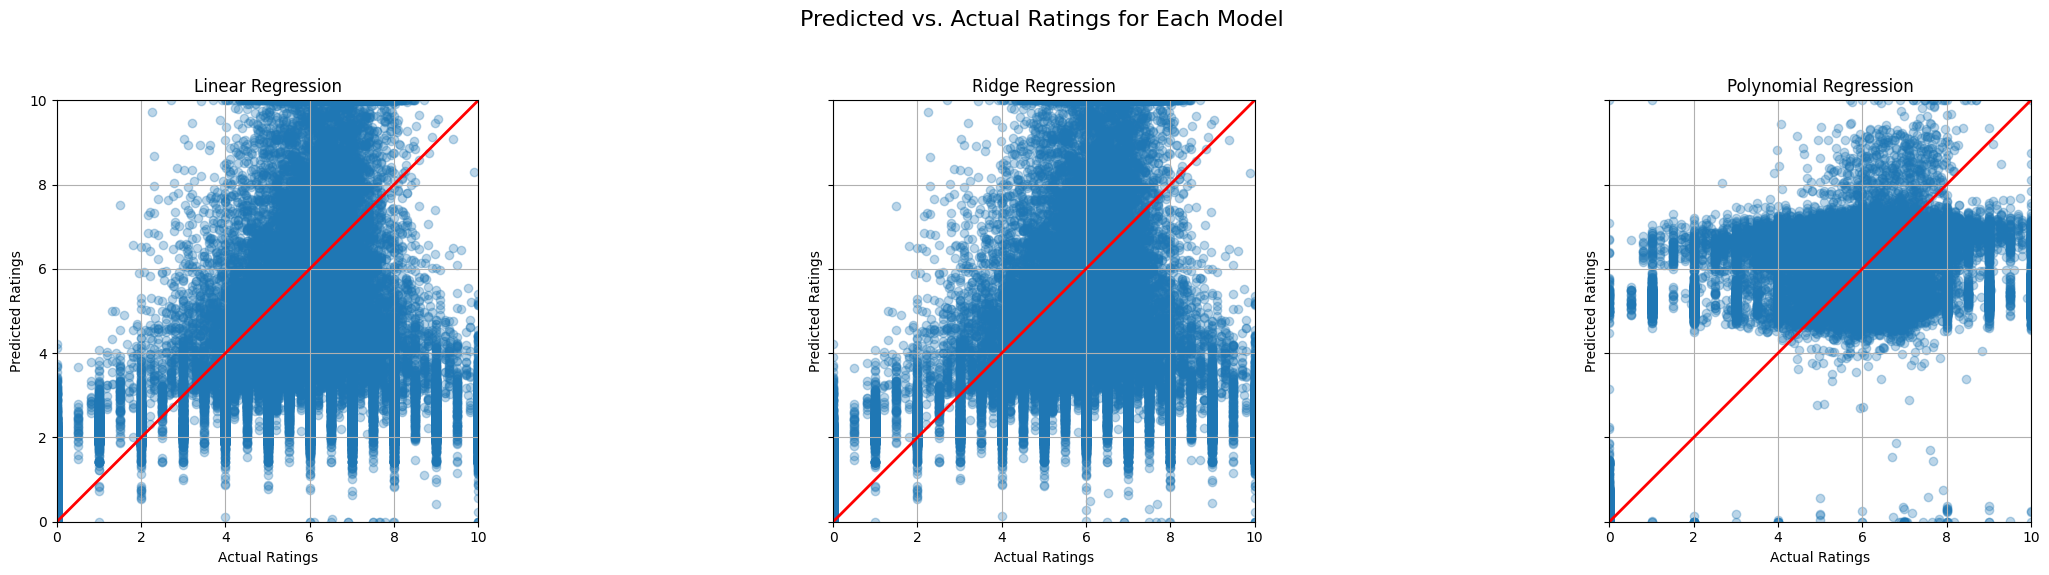

In [37]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots, one for each model
# https://stackoverflow.com/questions/71160580/
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
fig.suptitle('Predicted vs. Actual Ratings for Each Model', fontsize=16)

# A dictionary to hold the test predictions for each model
model_test_predictions = {
    'Linear Regression': y_test_pred_lr,
    'Ridge Regression': y_test_pred_ridge,
    'Polynomial Regression': y_test_pred_poly
}

# Loop through the models and create a plot for each
for ax, (model_name, y_pred) in zip(axes, model_test_predictions.items()):
    # Clip predictions to the valid range [0, 10]
    y_pred_clipped = np.clip(y_pred, 0, 10)

    # Create the scatter plot
    ax.scatter(y_test, y_pred_clipped, alpha=0.3)

    # Add the perfect prediction line
    ax.plot([0, 10], [0, 10], 'r', lw=2)

    # Set titles and labels
    ax.set_title(model_name)
    ax.set_xlabel("Actual Ratings")
    ax.set_ylabel("Predicted Ratings")
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()